# Fate/Grand Order Servants Dataset Analysis and Visualization

### Data Download

In [33]:
import requests

url = "https://api.atlasacademy.io/export/JP/nice_servant_lore_lang_en.json"

res = requests.request("GET", url)

rawData: list[dict] = res.json()

for s in rawData:
    s['traits'] = list(map(lambda x: x['name'], s['traits']))
    s['saberface'] = 'saberface' in s['traits']
    s['extra'] = s['className'] in ["moonCancer", "beast", "pretender", "alterEgo", "ruler", "avenger", "foreigner"]

f"There are {len(rawData)} servants with these columns: {list(rawData[0].keys())}"

"There are 392 servants with these columns: ['id', 'collectionNo', 'name', 'originalName', 'ruby', 'battleName', 'originalBattleName', 'classId', 'className', 'type', 'flag', 'rarity', 'cost', 'lvMax', 'extraAssets', 'gender', 'attribute', 'traits', 'starAbsorb', 'starGen', 'instantDeathChance', 'cards', 'hitsDistribution', 'cardDetails', 'atkBase', 'atkMax', 'hpBase', 'hpMax', 'relateQuestIds', 'trialQuestIds', 'growthCurve', 'atkGrowth', 'hpGrowth', 'bondGrowth', 'expGrowth', 'expFeed', 'bondEquip', 'valentineEquip', 'valentineScript', 'ascensionAdd', 'traitAdd', 'svtChange', 'ascensionImage', 'ascensionMaterials', 'skillMaterials', 'appendSkillMaterials', 'costumeMaterials', 'coin', 'script', 'skills', 'classPassive', 'extraPassive', 'appendPassive', 'noblePhantasms', 'profile', 'saberface', 'extra']"

### Data Cleaning

Some columns are not useful for the analysis so needs to be removed to improve performances


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(rawData)

df['illustrator'] = df['profile'].map(lambda x: x['illustrator'])
df = df[df["type"] != 'enemyCollectionDetail']

cleanData = df.filter(items=[
    "id",
    'name', 
    "atkMax",
    "hpMax",
    "atkGrowth",
    "hpGrowth",
    'className', 
    'type', 
    'attribute',
    'rarity', 
    'gender', 
    'traits',
    'illustrator', 
    'saberface', 
    'extra',
    'noblePhantasms',
    'cards'
])

cleanData.filter(items=[
    'name', 
    "atkMax",
    "hpMax",
    'className', 
    'type', 
    'attribute',
    'rarity', 
    'gender', 
    'illustrator'
])

,name,atkMax,hpMax,className,type,attribute,rarity,gender,illustrator
0,Altria Pendragon,11221,15150,saber,normal,earth,5,female,Takashi Takeuchi
1,Altria Pendragon (Alter),10248,11589,saber,normal,human,4,female,Takashi Takeuchi
2,Altria Pendragon (Lily),7726,10623,saber,normal,earth,4,female,Takashi Takeuchi
3,Nero Claudius,9449,11753,saber,normal,human,4,female,WADARCO
4,Nero Claudius (Bride),11607,14248,saber,normal,human,5,female,WADARCO
...,...,...,...,...,...,...,...,...,...
381,Lady Avalon,11556,13822,pretender,normal,earth,5,female,Taiki
382,Nine-Tattoo Dragon Elisa,9639,11055,pretender,normal,human,4,female,WADARCO
383,Tenochtitlan,8721,12344,pretender,normal,earth,4,female,Hiroki Saito (LASENGLE)
384,Cait Cú Cerpriestess,9831,11506,pretender,normal,earth,4,female,Kei Mochizuki


### Data Caching

In [35]:
cleanData.to_json("dataset.json", indent=1)

In [36]:
def configure(title, x_label, y_label, legend = None, grid = False):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if legend:
        plt.legend(legend)
    if grid:
        plt.grid()

### Servants per Class

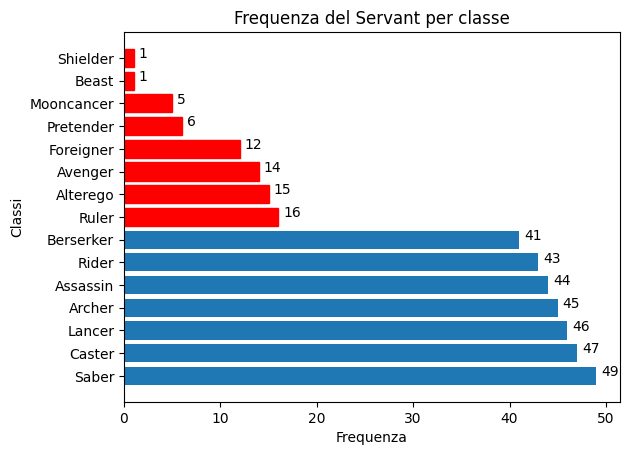

In [37]:
servants_per_class = cleanData.groupby("className").count().sort_values(by="id", ascending=False)["id"]
classes = list(map(lambda x: x.title(), servants_per_class.keys()))
values = servants_per_class.values
bars = plt.barh(classes, values)
for b in bars[7:]:
    b.set_color('r')
configure("Frequenza del Servant per classe", "Frequenza", "Classi")
for index,data in enumerate(values):
    plt.text(x= data+0.5 , y =index , s=f"{data}")
plt.savefig("presentation/images/frequency_by_class.png", bbox_inches="tight")
plt.show()

### Servants by attribute

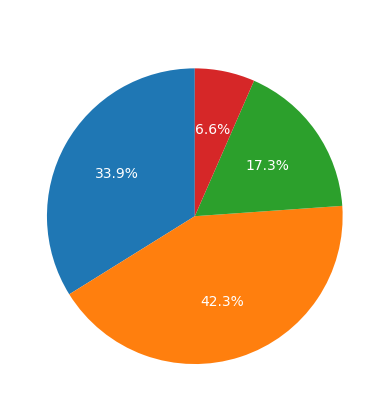

In [38]:
servants_by_attribute = cleanData[cleanData['attribute'] != "beast"].groupby('attribute').count()
_,texts,autotexts = plt.pie(
    servants_by_attribute["id"].values, 
    labels=list(map(lambda x: x.title(),servants_by_attribute["id"].keys())), 
    startangle = 90,
    autopct='%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')
for text in texts:
    text.set_color('white')
plt.title("Servants per attributo", color="white")
plt.savefig("presentation/images/frequency_by_attribute.png",  bbox_inches="tight", transparent=True)
plt.show()


### Servants by rarity


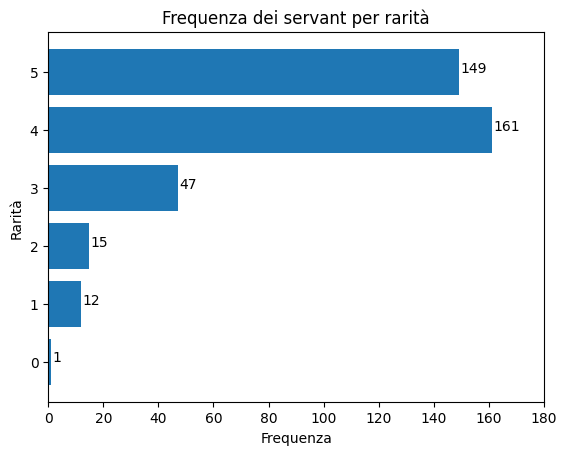

In [39]:
servants_per_rarity = df.groupby("rarity").count().sort_values(by="rarity", ascending=True)["id"]
classes = servants_per_rarity.keys()
values = servants_per_rarity.values
fig, ax = plt.subplots(1, 1)
bars = ax.barh(classes, values)
configure("Frequenza dei servant per rarità", "Frequenza", "Rarità")
ax.set_xlim(0, 180)
for index,data in enumerate(values):
    plt.text(x= data+0.5 , y =index , s=f"{data}")
plt.savefig("presentation/images/frequency_by_rarity.png", bbox_inches="tight")
plt.show()

## Statistics by rarity

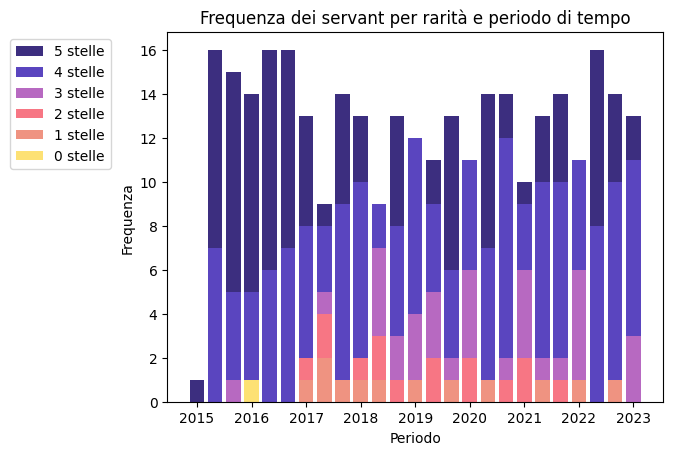

In [40]:
from datetime import datetime
ssr_color ='#3c2e7f' #'#013470'
sr_color ='#5a45bf' #'#014f9b'
r_color = '#b769c1'#'#016ac5'
b2_color = '#f77684'#'#229cff'
b1_color ='#ef9381' #'#74befa'
b0_color ='#fde174' #'#c6e0f5'

years = 8
blocks_per_year = 3

n = len(cleanData) // (blocks_per_year*years)
blocks = [cleanData[i:i+n] for i in range(0, len(cleanData),n)]

empty = pd.DataFrame({"rarity":[0,1,2,3,4,5],"id":[0,0,0,0,0,0]}).set_index("rarity")

groups = [list(i.groupby("rarity").count().filter(["id"]).add(empty, fill_value=0).values) for i in blocks]

groups.reverse()

x = range(0, len(blocks))
y = groups[0]
for i in groups[1:]:
    y = np.concatenate((y, i), axis=1)

fig,ax = plt.subplots()
ax.bar(x, y[5], bottom=y[4], color=ssr_color)
ax.bar(x, y[4], bottom=y[3], color=sr_color)
ax.bar(x, y[3], bottom=y[2], color=r_color)
ax.bar(x, y[2], bottom=y[1], color=b2_color)
ax.bar(x, y[1], bottom=y[0], color=b1_color)
ax.bar(x, y[0], color=b0_color)

ax.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
ax.set_xticklabels([
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023"
])
configure(
    "Frequenza dei servant per rarità e periodo di tempo", 
    "Periodo", 
    "Frequenza"
)
plt.legend(["5 stelle","4 stelle", "3 stelle","2 stelle", "1 stelle", "0 stelle" ], bbox_to_anchor=(-0.1,1.0))
plt.savefig("presentation/images/rarity_per_year_bar.png", bbox_inches="tight")
plt.show()

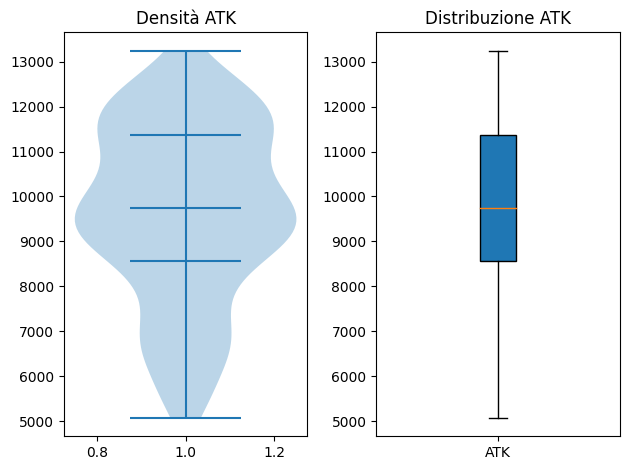

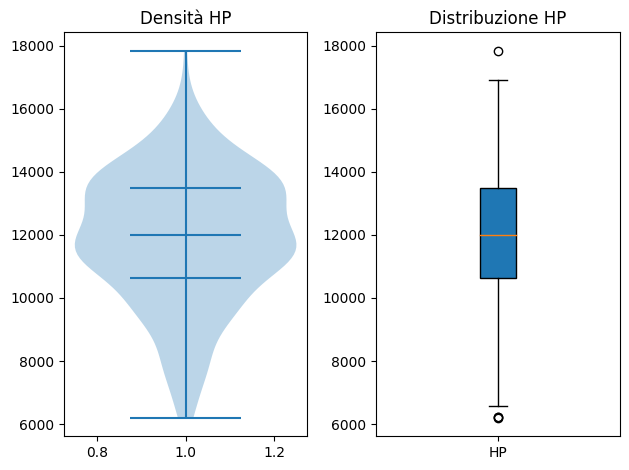

In [41]:
atk = cleanData['atkMax']

plt.subplot(1,2,1)
plt.title("Densità ATK")
plt.violinplot(atk, showmedians=True, quantiles=[.25,.75])

plt.subplot(1,2,2)
plt.title("Distribuzione ATK")
plt.boxplot(atk, labels=["ATK"], patch_artist=True)
plt.tight_layout()
plt.savefig("presentation/images/box_atk.png", bbox_inches="tight")
plt.show()

hp = cleanData['hpMax']

plt.subplot(1,2,1)
plt.title("Densità HP")
plt.violinplot(hp, showmedians=True, quantiles=[.25,.75])

plt.subplot(1,2,2)
plt.title("Distribuzione HP")
plt.boxplot(hp, labels=["HP"], patch_artist=True)
plt.tight_layout()
plt.savefig("presentation/images/box_hp.png", bbox_inches="tight")
plt.show()


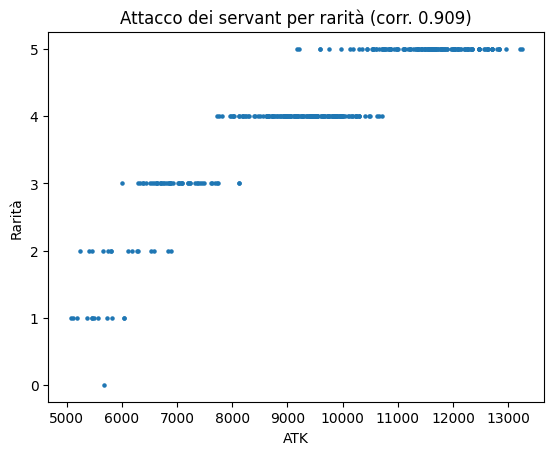

<Figure size 640x480 with 0 Axes>

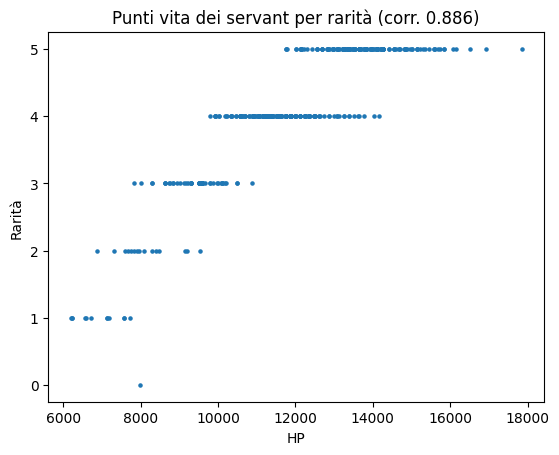

In [42]:
# Confronto rarita' e statistiche
# Confronto classe e statistiche
corr1 = cleanData["atkMax"].corr(cleanData["rarity"])
servants_statistics_clean = cleanData[(cleanData["atkMax"] < 20000) &(cleanData["hpMax"] < 22000)]
plt.scatter(servants_statistics_clean["atkMax"].values, servants_statistics_clean["rarity"].values,s = 5)
configure(
    f"Attacco dei servant per rarità (corr. {corr1:.3f})", 
    "ATK", 
    "Rarità"
)
plt.savefig("presentation/images/class_and_stats_atk.png", bbox_inches="tight")
plt.show()

plt.tight_layout(pad=4)
plt.show()

corr2 = cleanData["hpMax"].corr(cleanData["rarity"])
plt.scatter(servants_statistics_clean["hpMax"].values, servants_statistics_clean["rarity"].values,s = 5)
configure(
    f"Punti vita dei servant per rarità (corr. {corr2:.3f})", 
    "HP", 
    "Rarità"
)
plt.savefig("presentation/images/class_and_stats_hp.png", bbox_inches="tight")
plt.show()

### Statistics Growth


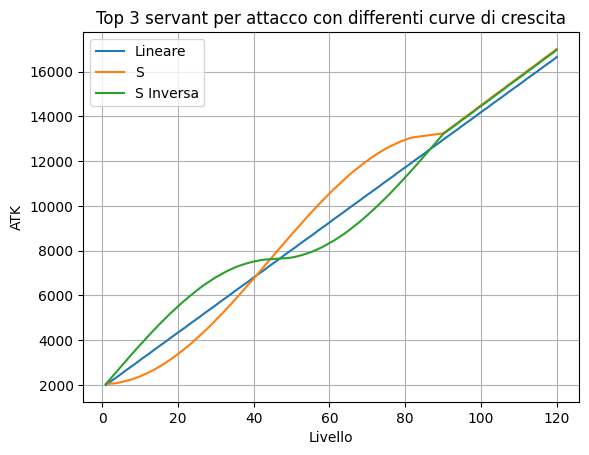

In [43]:
linear_growth = cleanData.loc[(cleanData['name'] == "Ibuki-Douji") & (cleanData['className'] == "berserker")].filter(["atkGrowth"]).values[0][0]
s_growth = cleanData.loc[(cleanData['name'] == "Jeanne d'Arc (Alter)") & (cleanData['className'] == "avenger")].filter(["atkGrowth"]).values[0][0]
reverse_s_growth = cleanData.loc[(cleanData['name'] == "Kama") & (cleanData['className'] == "avenger")].filter(["atkGrowth"]).values[0][0]

plt.plot(list(range(1, len(linear_growth)+1)), linear_growth)
plt.plot(list(range(1, len(s_growth)+1)), s_growth)
plt.plot(list(range(1, len(reverse_s_growth)+1)), reverse_s_growth)
configure("Top 3 servant per attacco con differenti curve di crescita", "Livello","ATK", legend=["Lineare", "S", "S Inversa"], grid=True)
plt.savefig("presentation/images/growth.png", bbox_inches="tight")
plt.show()

### Classes with the best and worst statistics

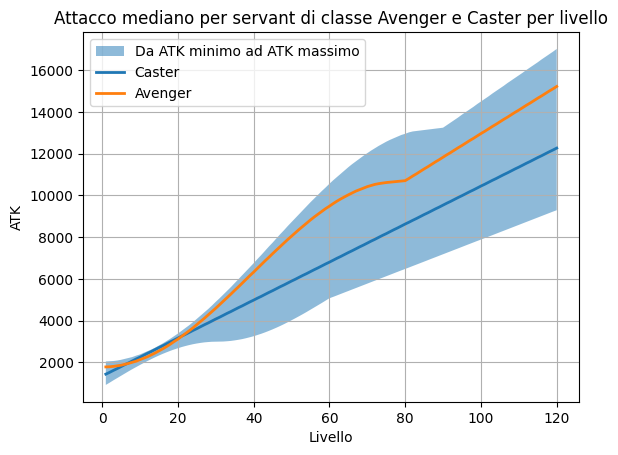

In [44]:
max_atk_growth = cleanData[cleanData["atkMax"] == cleanData["atkMax"].max()].filter(["atkGrowth"]).values[0][0]# cleanData.loc[(['name'] == "Ibuki-Douji") & (cleanData['className'] == "berserker")].filter(["atkGrowth"]).values[0][0]
min_atk_growth = cleanData[cleanData["atkMax"] == cleanData["atkMax"].min()].filter(["atkGrowth"]).values[0][0]# cleanData.loc[(['name'] == "Ibuki-Douji") & (cleanData['className'] == "berserker")].filter(["atkGrowth"]).values[0][0]

casters = cleanData[cleanData["className"] == "caster"]
caster_average_growth = casters[casters["atkMax"] == casters["atkMax"].median()].iloc[0].filter(["atkGrowth"]).values[0]
avengers = cleanData[cleanData["className"] == "avenger"]
avenger_average_growth = avengers[avengers["atkMax"] == avengers["atkMax"].quantile(interpolation='nearest')].iloc[0].filter(["atkGrowth"]).values[0]


to_120 = range(1, 120+1)

fig, ax = plt.subplots()
ax.fill_between(to_120, min_atk_growth, max_atk_growth, alpha=.5, linewidth=0)
ax.plot(to_120, caster_average_growth, linewidth=2)
ax.plot(to_120, avenger_average_growth, linewidth=2)
configure("Attacco mediano per servant di classe Avenger e Caster per livello", "Livello","ATK", legend=["Da ATK minimo ad ATK massimo", "Caster", "Avenger"], grid=True)
plt.savefig("presentation/images/caster_vs_avenger.png", bbox_inches="tight")
plt.show()

### Servants by illustrator

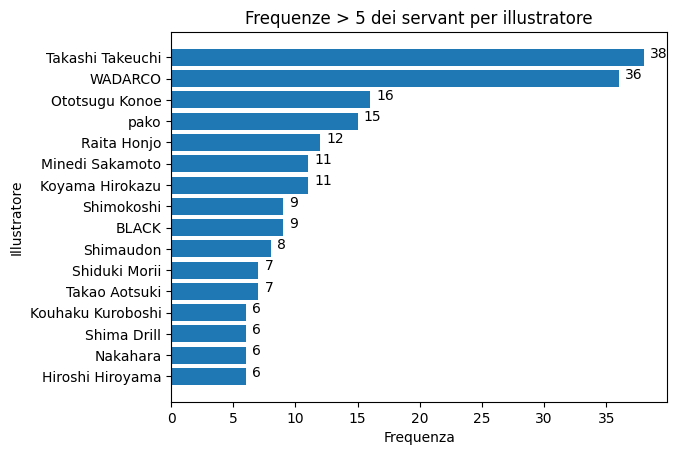

In [45]:
servants_by_illustrator = cleanData.groupby(by='illustrator').count().sort_values(by="id", ascending=True)["id"]
more_than_five  = servants_by_illustrator[servants_by_illustrator > 5]
illustrators = list(more_than_five.keys()) 
values = list(more_than_five.values)
plt.barh(illustrators, values)
for index,data in enumerate(values):
    plt.text(x= data+0.5 , y =index , s=f"{data}")
configure("Frequenze > 5 dei servant per illustratore", "Frequenza","Illustratore")
plt.savefig("presentation/images/illustrators.png", bbox_inches="tight")
plt.show()


### Servants illustrated by Takeuchi by the presence of the "saberface" trait

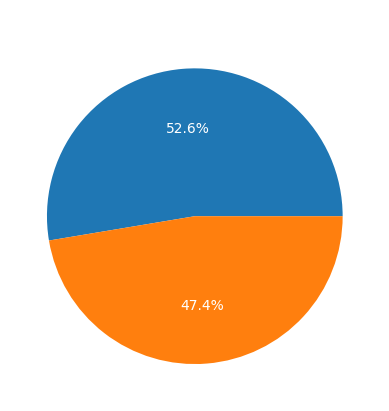

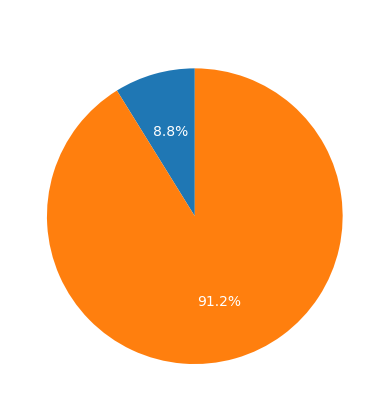

In [46]:
servants_by_take = cleanData[cleanData["illustrator"] == "Takashi Takeuchi"].copy()
servants_by_take = servants_by_take.groupby(by='saberface').count().sort_values(by="saberface", ascending=False)
values = servants_by_take["id"].values
_,texts,autotexts = plt.pie(values,labels=["Saberface","Non saberface"],startangle = 0,autopct='%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')
for text in texts:
    text.set_color('white')
plt.title("Servant illustrati da Takeuchi", color="white")
plt.savefig("presentation/images/saberface_take.png", bbox_inches="tight", transparent=True)
plt.show()

saberface = cleanData.groupby(by='saberface').count().sort_values(by="saberface", ascending=False)
values = saberface["id"].values
_,texts,autotexts = plt.pie(values,labels=["Saberface", "Non Saberface"],startangle = 90,autopct='%1.1f%%')
for autotext in autotexts:
    autotext.set_color('white')
for text in texts:
    text.set_color('white')
plt.title("Servant illustrati da tutti", color="white")
plt.savefig("presentation/images/saberface.png", bbox_inches="tight", transparent=True)
plt.show()

Servants illustrated by WADARCO by class being extra or not

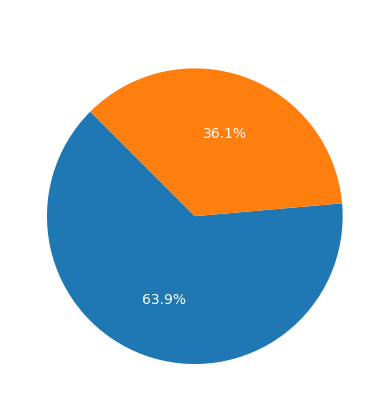

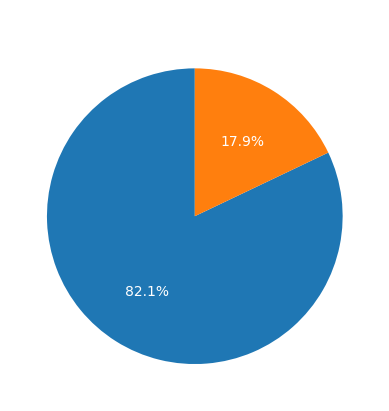

In [47]:
servants_by_wada = cleanData[cleanData["illustrator"] == "WADARCO"].copy()
servants_by_wada = servants_by_wada.groupby(by='extra').count().sort_values(by="id", ascending=False)
values = servants_by_wada["id"].values
_,texts,autotexts = plt.pie(values,labels=list(map(lambda x: "Extra" if x else "Non-Extra",servants_by_wada["id"].keys())),autopct='%1.1f%%', startangle=135)
for autotext in autotexts:
    autotext.set_color('white')
for text in texts:
    text.set_color('white')
plt.title("Servant illustrati da WADARCO", color="white")
plt.savefig("presentation/images/wadarco.png", bbox_inches="tight", transparent=True)
plt.show()

servants_by_extra = cleanData.groupby(by='extra').count().sort_values(by="id", ascending=False)
values = servants_by_extra["id"].values
_,texts,autotexts = plt.pie(values,labels=list(map(lambda x: "Extra" if x else "Non-Extra",servants_by_extra["id"].keys())),autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
for text in texts:
    text.set_color('white')
plt.title("Servants illustrati da tutti", color="white")
plt.savefig("presentation/images/ill_extra.png", bbox_inches="tight", transparent=True)
plt.show()
